In [285]:
# ！pip install functorch
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import pandas as pd
import scipy
from scipy import stats
import numpy as np
from os import path
import torchvision
import matplotlib.pyplot as plt
import time
from datetime import date
from datetime import timedelta

In [286]:
MA_DAYS = 25
trading_days_in_year = 252

# Import raw data from yahoo finance

In [287]:
from google.colab import drive
drive.mount('/content/drive')
data_files_path_prefix = "/content/drive/MyDrive"
data_files_path = "ML-Portfolio-Data"
data_files_path = path.join(data_files_path_prefix, data_files_path)

high_risk_file = 'SPY.csv'
low_risk_file = 'IEF.csv'
high_risk = pd.read_csv(path.join(data_files_path, high_risk_file))
low_risk = pd.read_csv(path.join(data_files_path, low_risk_file))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [288]:
# Read files from the same directory
#high_risk = pd.read_csv('SPY.csv')
#low_risk = pd.read_csv('IEF.csv')

In [289]:
print(high_risk.shape)
print(low_risk.shape)

(5147, 7)
(5147, 7)


In [290]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-07-30,89.320000,91.400002,88.720001,90.940002,61.380939,47532200
1,2002-07-31,90.489998,91.550003,89.250000,91.160004,61.529453,44669900
2,2002-08-01,90.879997,91.349998,88.330002,88.779999,59.923054,66571900
3,2002-08-02,88.500000,88.910004,85.620003,86.790001,58.579895,51772900
4,2002-08-05,86.489998,86.930000,83.550003,83.769997,56.541496,47191300


In [291]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-07-30,81.940002,82.120003,81.699997,81.769997,45.672558,41300
1,2002-07-31,82.050003,82.580002,82.050003,82.519997,46.091442,32600
2,2002-08-01,82.540001,82.900002,82.519997,82.860001,46.281376,71400
3,2002-08-02,83.019997,83.699997,82.900002,83.500000,46.638828,120300
4,2002-08-05,83.680000,83.919998,83.529999,83.919998,46.873459,159300


# Build Dataset for ML Portfolio

In [292]:
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

## Enrich data

### Calculate daily returns

In [293]:
def add_daily_return(market_data):
    market_data["Daily Return"]  = market_data['Close'] - market_data['Open']

add_daily_return(high_risk)
add_daily_return(low_risk)

### Calculate moving average (MA) of daily returns

In [294]:
def add_moving_average(market_data, ma_days):
    temp_vars = []

    for i in range(0,ma_days):
        temp_var = "M_{0}".format(i)
        market_data[temp_var] = market_data["Daily Return"].shift(i)
        temp_vars.append(temp_var)

    market_data["MA"] = market_data[temp_vars].mean(axis=1)

    for i in range(0,ma_days):
        temp_var = "M_{0}".format(i)
        market_data.drop(temp_var, axis = 1, inplace = True)

add_moving_average(high_risk, MA_DAYS)
add_moving_average(low_risk, MA_DAYS)

In [295]:
high_risk.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA
5142,2022-12-30,380.640015,382.579987,378.429993,382.429993,382.429993,83975100,1.789978,-0.368799
5143,2023-01-03,384.369995,386.429993,377.829987,380.820007,380.820007,74850700,-3.549988,-0.530798
5144,2023-01-04,383.179993,385.880005,380.000000,383.760010,383.760010,85934100,0.580017,-0.380398
5145,2023-01-05,381.720001,381.839996,378.760010,379.380005,379.380005,76970500,-2.339996,-0.441199
5146,2023-01-06,382.609985,389.250000,379.410004,388.079987,388.079987,104041300,5.470002,-0.709999


In [296]:
low_risk.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA
5142,2022-12-30,95.860001,96.269997,95.620003,95.779999,95.779999,5039800,-0.080002,0.050399
5143,2023-01-03,96.910004,97.000000,96.339996,96.529999,96.529999,6808300,-0.380005,0.025599
5144,2023-01-04,97.339996,97.419998,96.989998,97.269997,97.269997,7800100,-0.069999,0.025599
5145,2023-01-05,96.699997,97.220001,96.570000,97.129997,97.129997,3177900,0.430000,0.043600
5146,2023-01-06,97.169998,98.430000,97.080002,98.379997,98.379997,6807700,1.209999,0.050399


### Calculate ROE

In [297]:
def add_roe(market_data):    
    market_data["Next Close"] = market_data["Close"].shift(-1)
    market_data["ROE"] = (market_data["Next Close"] - market_data["Close"]) / market_data['Close']

add_roe(high_risk)
add_roe(low_risk)

In [298]:
def add_roe_binary(market_data, tau=-0.005):    
    market_data["ROE Binary"] = np.where(market_data["ROE"].values < tau, 0, 1)

add_roe_binary(high_risk)
add_roe_binary(low_risk)

In [299]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Next Close,ROE,ROE Binary
0,2002-07-30,89.320000,91.400002,88.720001,90.940002,61.380939,47532200,1.620002,1.620002,91.160004,0.002419,1
1,2002-07-31,90.489998,91.550003,89.250000,91.160004,61.529453,44669900,0.670006,1.145004,88.779999,-0.026108,0
2,2002-08-01,90.879997,91.349998,88.330002,88.779999,59.923054,66571900,-2.099998,0.063337,86.790001,-0.022415,0
3,2002-08-02,88.500000,88.910004,85.620003,86.790001,58.579895,51772900,-1.709999,-0.379997,83.769997,-0.034797,0
4,2002-08-05,86.489998,86.930000,83.550003,83.769997,56.541496,47191300,-2.720001,-0.847998,86.589996,0.033664,1


In [300]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Next Close,ROE,ROE Binary
0,2002-07-30,81.940002,82.120003,81.699997,81.769997,45.672558,41300,-0.170005,-0.170005,82.519997,0.009172,1
1,2002-07-31,82.050003,82.580002,82.050003,82.519997,46.091442,32600,0.469994,0.149994,82.860001,0.004120,1
2,2002-08-01,82.540001,82.900002,82.519997,82.860001,46.281376,71400,0.320000,0.206663,83.500000,0.007724,1
3,2002-08-02,83.019997,83.699997,82.900002,83.500000,46.638828,120300,0.480003,0.274998,83.919998,0.005030,1
4,2002-08-05,83.680000,83.919998,83.529999,83.919998,46.873459,159300,0.239998,0.267998,83.239998,-0.008103,0


## Build feature space

In [301]:
def remove_for_ma(market_data, ma_days):
  return market_data[ma_days:]

high_risk = remove_for_ma(high_risk, MA_DAYS)
low_risk = remove_for_ma(low_risk, MA_DAYS)

In [302]:
print(high_risk.shape)

(5122, 12)


In [303]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Next Close,ROE,ROE Binary
25,2002-09-04,88.610001,90.250000,88.059998,89.540001,60.436001,51099500,0.930000,0.088801,88.779999,-0.008488,0
26,2002-09-05,88.489998,89.430000,87.500000,88.779999,59.923054,67250900,0.290001,0.073600,90.000000,0.013742,1
27,2002-09-06,89.750000,90.570000,89.339996,90.000000,60.746498,38622200,0.250000,0.167600,90.660004,0.007333,1
28,2002-09-09,89.099998,91.349998,88.800003,90.660004,61.191929,33998400,1.560006,0.298400,91.699997,0.011471,1
29,2002-09-10,91.139999,91.779999,90.559998,91.699997,61.893936,41416600,0.559998,0.429600,91.129997,-0.006216,0


In [307]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Next Close,ROE,ROE Binary
25,2002-09-04,85.160004,85.449997,85.080002,85.199997,47.752071,0.023505,0.135391,0.912126,85.540001,0.003991,1
26,2002-09-05,85.599998,85.650002,85.190002,85.540001,47.942638,0.017606,-0.203112,0.564337,84.879997,-0.007716,0
27,2002-09-06,85.089996,85.250000,84.839996,84.879997,47.572742,0.009791,-0.710926,0.216542,84.760002,-0.001414,1
28,2002-09-09,84.940002,85.150002,84.750000,84.760002,47.505463,0.027002,-0.609368,-0.216563,85.059998,0.003539,1
29,2002-09-10,84.709999,85.209999,84.660004,85.059998,47.673588,0.006507,1.184878,-0.144378,84.750000,-0.003644,1


In [305]:
def standardize_columns(market_data, columns):
  for column in columns:
    market_data.loc[:,column] = market_data[column]/market_data[column].std()

standardize_columns(high_risk, ['Volume', 'Daily Return', 'MA'])
standardize_columns(low_risk, ['Volume', 'Daily Return', 'MA'])

In [306]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Next Close,ROE,ROE Binary
25,2002-09-04,88.610001,90.250000,88.059998,89.540001,60.436001,0.550024,0.479605,0.276737,88.779999,-0.008488,0
26,2002-09-05,88.489998,89.430000,87.500000,88.779999,59.923054,0.723874,0.149555,0.229367,90.000000,0.013742,1
27,2002-09-06,89.750000,90.570000,89.339996,90.000000,60.746498,0.415721,0.128926,0.522307,90.660004,0.007333,1
28,2002-09-09,89.099998,91.349998,88.800003,90.660004,61.191929,0.365951,0.804501,0.929931,91.699997,0.011471,1
29,2002-09-10,91.139999,91.779999,90.559998,91.699997,61.893936,0.445799,0.288793,1.338801,91.129997,-0.006216,0


In [180]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Next Close,ROE,ROE Binary
25,2002-09-04,85.160004,85.449997,85.080002,85.199997,47.752071,0.023505,0.135391,0.912126,85.540001,0.003991,1
26,2002-09-05,85.599998,85.650002,85.190002,85.540001,47.942638,0.017606,-0.203112,0.564337,84.879997,-0.007716,0
27,2002-09-06,85.089996,85.250000,84.839996,84.879997,47.572742,0.009791,-0.710926,0.216542,84.760002,-0.001414,1
28,2002-09-09,84.940002,85.150002,84.750000,84.760002,47.505463,0.027002,-0.609368,-0.216563,85.059998,0.003539,1
29,2002-09-10,84.709999,85.209999,84.660004,85.059998,47.673588,0.006507,1.184878,-0.144378,84.750000,-0.003644,1


In [182]:
ml_master_dataset = pd.concat([low_risk.add_prefix('l_'), high_risk.add_prefix('h_')], join='outer', axis=1)[['l_Date','l_Daily Return','l_MA','l_Volume','h_Daily Return','h_MA','h_Volume','h_ROE Binary']]
ml_master_dataset

,l_Date,l_Daily Return,l_MA,l_Volume,h_Daily Return,h_MA,h_Volume,h_ROE Binary
25,2002-09-04,0.135391,0.912126,0.023505,0.479605,0.276737,0.550024,0
26,2002-09-05,-0.203112,0.564337,0.017606,0.149555,0.229367,0.723874,1
27,2002-09-06,-0.710926,0.216542,0.009791,0.128926,0.522307,0.415721,1
28,2002-09-09,-0.609368,-0.216563,0.027002,0.804501,0.929931,0.365951,1
29,2002-09-10,1.184878,-0.144378,0.006507,0.288793,1.338801,0.445799,0
...,...,...,...,...,...,...,...,...
5142,2022-12-30,-0.270837,0.826825,1.532486,0.923099,-1.149319,0.903889,1
5143,2023-01-03,-1.286460,0.419968,2.070246,-1.830743,-1.654172,0.805676,1
5144,2023-01-04,-0.236973,0.419968,2.371829,0.299117,-1.185467,0.924976,0
5145,2023-01-05,1.455712,0.715269,0.966325,-1.206745,-1.374945,0.828493,1


## Build graph

In [184]:
lr = 1e-1
n_epochs = 500
torch.manual_seed(42)
lambda1 = 1e-3 #0.5
lambda2 = 1e-3 #0.5

loss_fn = nn.BCELoss()

batch_size = 32

In [185]:
folds=10
splits=KFold(n_splits=folds,shuffle=True,random_state=42)

In [186]:
#no cross-validation

def train_and_get_a_b(dataset):

  a = torch.randn((6), requires_grad=True, dtype=torch.double)
  b = torch.randn((6), requires_grad=True, dtype=torch.double)
  # print(a, a.size(), b, b.size())

  optimizer = optim.SGD([a, b], lr=lr)

  X_tensor = torch.from_numpy(dataset[:,:-1])
  Y_tensor = torch.from_numpy(dataset[:,-1])
  # print(X_tensor, Y_tensor)    
    
  for epoch in range(n_epochs):
    
      yhat = torch.exp(torch.matmul(X_tensor, a)) / (torch.exp (torch.matmul(X_tensor, a)) + torch.exp(torch.matmul(X_tensor, b)))

      loss = loss_fn(yhat, Y_tensor)
      loss.backward()   

      if epoch % 10 == 0:
        print(f"Epoch: {epoch}. Loss: {loss}")

      optimizer.step()
      optimizer.zero_grad()
      
  return a,b

# Build Dataset for MV Portfolio

In [187]:
mv_master_dataset = pd.concat([low_risk.add_prefix('l_'), high_risk.add_prefix('h_')], join='outer', axis=1)[['l_Date','l_Close','h_Close']]
mv_master_dataset

,l_Date,l_Close,h_Close
25,2002-09-04,85.199997,89.540001
26,2002-09-05,85.540001,88.779999
27,2002-09-06,84.879997,90.000000
28,2002-09-09,84.760002,90.660004
29,2002-09-10,85.059998,91.699997
...,...,...,...
5142,2022-12-30,95.779999,382.429993
5143,2023-01-03,96.529999,380.820007
5144,2023-01-04,97.269997,383.760010
5145,2023-01-05,97.129997,379.380005


In [188]:
def get_mv_dataset_for_date(date):
  startdate = pd.to_datetime(date) - delta_50weeks
  enddate = pd.to_datetime(date)
  mask = (pd.to_datetime(mv_master_dataset['l_Date']) > startdate) & (pd.to_datetime(mv_master_dataset['l_Date']) <= enddate)
  subset = mv_master_dataset.loc[mask]
  dataset = subset[['l_Close','h_Close']]
  return dataset

In [189]:
def get_annual_sample_return_and_covariance(data):
    daily_return = data.pct_change()
    annual_return = daily_return.mean() * trading_days_in_year
    daily_covariance = daily_return.cov()
    annual_covariance = daily_covariance * trading_days_in_year
    return annual_return, annual_covariance

In [190]:
def get_sample_return_and_covariance(data):
    daily_return = data.pct_change().mean()
    daily_covariance = data.pct_change().cov()
    return daily_return * len(data), daily_covariance * len(data)

In [191]:
def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    
    def  f(x,CovarReturns):
         
        func = np.matmul(np.matmul(x,CovarReturns ), x.T)
        return func

    def constraintEq(x):
        AEq=np.ones(x.shape)
        bEq=1
        EqconstraintVal = np.matmul(AEq,x.T)-bEq 
        return EqconstraintVal
    
    def constraintIneq(x, MeanReturns, R):
        AIneq = np.array(MeanReturns)
        bIneq = R
        IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
        return IneqconstraintVal
    

    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq},
            {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                        x0 = xinit,   bounds = bnds, constraints = cons, tol = TERMINATION)
    
    return  opt

In [192]:
def get_mv_backtest_data(date):
  startdate = pd.to_datetime(date)
  enddate = pd.to_datetime(date) + delta_1week
    
  low_risk_mask = (pd.to_datetime(low_risk['Date']) > startdate) & (pd.to_datetime(low_risk['Date']) <= enddate)
  high_risk_mask = (pd.to_datetime(high_risk['Date']) > startdate) & (pd.to_datetime(high_risk['Date']) <= enddate)
  low_risk_backtest_data = low_risk.loc[low_risk_mask]
  high_risk_backtest_data = high_risk.loc[high_risk_mask]

  return low_risk_backtest_data, high_risk_backtest_data

In [193]:
def calculate_backtest_return(backtest_data):
  first_open = backtest_data.iloc[0]['Open']
  last_close = backtest_data.iloc[-1]['Close']
  return (last_close - first_open)/first_open

In [194]:
def calculate_mv_backtest_return(low_risk_backtest_data, high_risk_backtest_data, high_risk_weight):
  low_return = calculate_backtest_return(low_risk_backtest_data)
  high_return = calculate_backtest_return(high_risk_backtest_data)
  # print(low_return)
  # print(high_return)
  return low_return * (1-high_risk_weight) + high_return * high_risk_weight

In [195]:
def get_mv_backtest_return(date, high_risk_weight):
  low_risk_backtest_data, high_risk_backtest_data = get_mv_backtest_data(date)
  return calculate_mv_backtest_return(low_risk_backtest_data, high_risk_backtest_data, high_risk_weight)

# Backtesting

In [197]:
first_date = date(2003,9,21)
last_date = date(2023,1,1)

In [198]:
delta_50weeks = timedelta(weeks=50)
delta_1week = timedelta(weeks=1)

In [199]:
daterange = pd.date_range(first_date, last_date, freq='1W')
daterange

DatetimeIndex(['2003-09-21', '2003-09-28', '2003-10-05', '2003-10-12',
               '2003-10-19', '2003-10-26', '2003-11-02', '2003-11-09',
               '2003-11-16', '2003-11-23',
               ...
               '2022-10-30', '2022-11-06', '2022-11-13', '2022-11-20',
               '2022-11-27', '2022-12-04', '2022-12-11', '2022-12-18',
               '2022-12-25', '2023-01-01'],
              dtype='datetime64[ns]', length=1007, freq='W-SUN')

In [200]:
def get_ml_dataset_for_date(date):
  startdate = pd.to_datetime(date) - delta_50weeks
  enddate = pd.to_datetime(date)
  mask = (pd.to_datetime(ml_master_dataset['l_Date']) > startdate) & (pd.to_datetime(ml_master_dataset['l_Date']) <= enddate)
  subset = ml_master_dataset.loc[mask]
  # print(subset)
  dataset = subset[['l_Daily Return','l_MA','l_Volume','h_Daily Return','h_MA','h_Volume','h_ROE Binary']].to_numpy()
  # print(dataset)
  return dataset

### First date

In [201]:
dataset = get_ml_dataset_for_date(first_date)
dataset[:-1]

array([[ 0.10155789,  1.89647755,  0.02441736, ..., -0.97480731,
         0.57250387,  1.        ],
       [ 0.40625526,  1.88335059,  0.04092873, ..., -0.59959326,
         0.8560541 ,  0.        ],
       [ 0.16925525,  1.88991473,  0.02873525, ..., -0.83893149,
         0.86063301,  1.        ],
       ...,
       [ 0.20311239,  0.702162  ,  0.02435655, ...,  0.53227856,
         0.40786757,  1.        ],
       [ 1.11718079,  1.03027115,  0.05385199, ...,  0.41510118,
         0.3432117 ,  1.        ],
       [-0.06772444,  1.33868853,  0.04019894, ...,  0.66191837,
         0.32553542,  0.        ]])

In [202]:
a,b = train_and_get_a_b(dataset[:-1])

Epoch: 0. Loss: 1.2250968985965647
Epoch: 10. Loss: 1.0422664556524388
Epoch: 20. Loss: 0.9103199651473237
Epoch: 30. Loss: 0.8211627365206585
Epoch: 40. Loss: 0.7621501754153689
Epoch: 50. Loss: 0.7225548587061368
Epoch: 60. Loss: 0.6954737927837602
Epoch: 70. Loss: 0.6767014150071979
Epoch: 80. Loss: 0.6635699476207669
Epoch: 90. Loss: 0.6543132706623938
Epoch: 100. Loss: 0.6477360885029361
Epoch: 110. Loss: 0.6430221585728905
Epoch: 120. Loss: 0.6396116532648428
Epoch: 130. Loss: 0.6371191459597229
Epoch: 140. Loss: 0.635278073957452
Epoch: 150. Loss: 0.6339030752274836
Epoch: 160. Loss: 0.6328644511700781
Epoch: 170. Loss: 0.6320708338895114
Epoch: 180. Loss: 0.6314573915018703
Epoch: 190. Loss: 0.6309777707686528
Epoch: 200. Loss: 0.6305985665087154
Epoch: 210. Loss: 0.6302955051416969
Epoch: 220. Loss: 0.6300507962110538
Epoch: 230. Loss: 0.6298512837528443
Epoch: 240. Loss: 0.6296871483410416
Epoch: 250. Loss: 0.6295509903413822
Epoch: 260. Loss: 0.6294371785102312
Epoch: 270. L

In [203]:
with torch.no_grad():
  y_test = torch.exp(torch.matmul(torch.from_numpy(dataset[-1][:-1]), a)) / (torch.exp (torch.matmul(torch.from_numpy(dataset[-1][:-1]), a)) + torch.exp(torch.matmul(torch.from_numpy(dataset[-1][:-1]), b)))
  print(y_test)

tensor(0.6920, dtype=torch.float64)


In [204]:
def calculate_ml_portfolio_weights(x, k):
  return 0 if x < k else 1

In [205]:
weight = calculate_ml_portfolio_weights(y_test.numpy(), 0.5)
weight

1

In [206]:
def get_backtest_data(date, weight):
  startdate = pd.to_datetime(date)
  enddate = pd.to_datetime(date) + delta_1week

  investment = low_risk if weight == 0 else high_risk
    
  backtest_mask = (pd.to_datetime(investment['Date']) > startdate) & (pd.to_datetime(investment['Date']) <= enddate)
  backtest_data = investment.loc[backtest_mask]

  return backtest_data

In [207]:
def calculate_backtest_return(backtest_data):
  first_open = backtest_data.iloc[0]['Open']
  last_close = backtest_data.iloc[-1]['Close']
  return (last_close - first_open)/first_open

In [208]:
def get_backtest_return(date, weight):
  backtest_data = get_backtest_data(date, weight)
  return calculate_backtest_return(backtest_data)

In [209]:
backtest_data = get_backtest_data(first_date, weight)
backtest_data.iloc[-1]['Close']
backtest_data.iloc[0]['Open']

102.849998

In [210]:
get_backtest_return(first_date, weight)

-0.028196412799152443

## Back test for all range

### ML Portfolio

In [257]:
parameters = pd.DataFrame(columns=['a','b','prob'])

for date in daterange:
  print(date)
  dataset = get_ml_dataset_for_date(date)
  a,b = train_and_get_a_b(dataset[:-1])  
  with torch.no_grad():
    y_test = torch.exp(torch.matmul(torch.from_numpy(dataset[-1][:-1]), a)) / (torch.exp (torch.matmul(torch.from_numpy(dataset[-1][:-1]), a)) + torch.exp(torch.matmul(torch.from_numpy(dataset[-1][:-1]), b)))
    print(y_test)
    parameters.loc[date] = [a,b,y_test.numpy()]

Streaming output truncated to the last 5000 lines.
Epoch: 430. Loss: 0.5791454423362592
Epoch: 440. Loss: 0.579143105818223
Epoch: 450. Loss: 0.5791411383938524
Epoch: 460. Loss: 0.5791394816412584
Epoch: 470. Loss: 0.5791380864125462
Epoch: 480. Loss: 0.5791369113555456
Epoch: 490. Loss: 0.5791359216725754
tensor(0.9895, dtype=torch.float64)
2021-03-07 00:00:00
Epoch: 0. Loss: 1.9445291614467444
Epoch: 10. Loss: 0.9326522619547405
Epoch: 20. Loss: 0.6639824427146934
Epoch: 30. Loss: 0.609756859566522
Epoch: 40. Loss: 0.5981846293448686
Epoch: 50. Loss: 0.5939786154194254
Epoch: 60. Loss: 0.5911794486064991
Epoch: 70. Loss: 0.5889668295230647
Epoch: 80. Loss: 0.5871583291896727
Epoch: 90. Loss: 0.5856703403978939
Epoch: 100. Loss: 0.5844444590642718
Epoch: 110. Loss: 0.5834341948722712
Epoch: 120. Loss: 0.5826014073832411
Epoch: 130. Loss: 0.5819146539729523
Epoch: 140. Loss: 0.5813480336331658
Epoch: 150. Loss: 0.5808802434342614
Epoch: 160. Loss: 0.580493783231326
Epoch: 170. Loss: 0

In [258]:
ks = np.arange(0, 1, 0.05)
backtest_returns = pd.DataFrame(columns = ks)

for date in daterange:  
  print(date)
  prob = parameters.loc[date]['prob']
  rets = []
  for k in ks:
    weight = calculate_ml_portfolio_weights(prob, k)
    rets.append(get_backtest_return(date, weight))
  backtest_returns.loc[date] = rets

2003-09-21 00:00:00
2003-09-28 00:00:00
2003-10-05 00:00:00
2003-10-12 00:00:00
2003-10-19 00:00:00
2003-10-26 00:00:00
2003-11-02 00:00:00
2003-11-09 00:00:00
2003-11-16 00:00:00
2003-11-23 00:00:00
2003-11-30 00:00:00
2003-12-07 00:00:00
2003-12-14 00:00:00
2003-12-21 00:00:00
2003-12-28 00:00:00
2004-01-04 00:00:00
2004-01-11 00:00:00
2004-01-18 00:00:00
2004-01-25 00:00:00
2004-02-01 00:00:00
2004-02-08 00:00:00
2004-02-15 00:00:00
2004-02-22 00:00:00
2004-02-29 00:00:00
2004-03-07 00:00:00
2004-03-14 00:00:00
2004-03-21 00:00:00
2004-03-28 00:00:00
2004-04-04 00:00:00
2004-04-11 00:00:00
2004-04-18 00:00:00
2004-04-25 00:00:00
2004-05-02 00:00:00
2004-05-09 00:00:00
2004-05-16 00:00:00
2004-05-23 00:00:00
2004-05-30 00:00:00
2004-06-06 00:00:00
2004-06-13 00:00:00
2004-06-20 00:00:00
2004-06-27 00:00:00
2004-07-04 00:00:00
2004-07-11 00:00:00
2004-07-18 00:00:00
2004-07-25 00:00:00
2004-08-01 00:00:00
2004-08-08 00:00:00
2004-08-15 00:00:00
2004-08-22 00:00:00
2004-08-29 00:00:00


In [259]:
backtest_mean = backtest_returns.mean()
backtest_var = backtest_returns.var()
print(backtest_mean)
print(backtest_var)

0.00    0.001456
0.05    0.001456
0.10    0.001456
0.15    0.001456
0.20    0.001456
0.25    0.001313
0.30    0.001310
0.35    0.001310
0.40    0.001449
0.45    0.001412
0.50    0.001171
0.55    0.000878
0.60    0.000853
0.65    0.000776
0.70    0.000631
0.75    0.001024
0.80    0.001051
0.85    0.000569
0.90    0.000621
0.95    0.000470
dtype: float64
0.00    0.000522
0.05    0.000522
0.10    0.000522
0.15    0.000522
0.20    0.000522
0.25    0.000507
0.30    0.000505
0.35    0.000505
0.40    0.000497
0.45    0.000489
0.50    0.000466
0.55    0.000430
0.60    0.000379
0.65    0.000344
0.70    0.000287
0.75    0.000222
0.80    0.000183
0.85    0.000148
0.90    0.000112
0.95    0.000081
dtype: float64


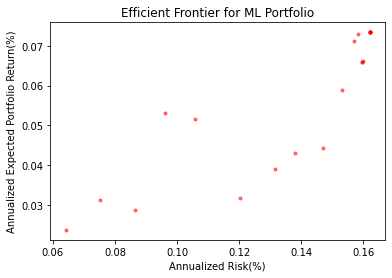

In [260]:
NoPoints = len(backtest_mean)

colours = "red"
area = np.pi*3

plt.title('Efficient Frontier for ML Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter( np.sqrt(backtest_var * (trading_days_in_year /5)), backtest_mean * (trading_days_in_year /5),s=area, c=colours, alpha =0.5)
plt.show()

### MV Portfolio

In [267]:
dataset = get_mv_dataset_for_date(date(2023,1,1))
r, cov = get_sample_return_and_covariance(dataset)

In [268]:
len(dataset)

241

In [269]:
print(r)
print(cov)

l_Close   -0.149595
h_Close   -0.148826
dtype: float64
          l_Close   h_Close
l_Close  0.010103  0.004556
h_Close  0.004556  0.057944


In [238]:
def calculate_markovitz_weights(r, cov, m):
  r = r.to_numpy()
  cov = cov.to_numpy()
  cov_inv = np.linalg.inv(cov)
  ones = [1,1]
  a = np.matmul(np.matmul(r, cov_inv), ones)
  b = np.matmul(np.matmul(r, cov_inv), r)
  c = np.matmul(np.matmul(ones, cov_inv), ones)
  # print(r, cov, cov_inv,a,b,c)
  numerator = b * np.matmul(cov_inv, ones) - a * np.matmul(cov_inv, r)  + m * (c * np.matmul(cov_inv, r) - a * np.matmul(cov_inv, ones))
  denominator = b*c-pow(a,2)
  x =  numerator / denominator
  # print(numerator,denominator,x)
  #/ (b*c-a^2) 
  return x

In [239]:
x = calculate_markovitz_weights(r , cov , 0.01)
x

array([-206.6925489,  207.6925489])

In [216]:
ms = np.arange(0.02, 0.11, 0.005)
ms

array([0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 , 0.055, 0.06 ,
       0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095, 0.1  , 0.105])

In [241]:
def adjust_weight_for_constraint(weight):
  if weight < 0:
    return 0
  if weight > 1:
    return 1
  return weight

In [218]:
mv_backtest_weights = pd.DataFrame(columns = ms)

for date in daterange:
  print(date)
  dataset = get_mv_dataset_for_date(date)
  r, cov = get_sample_return_and_covariance(dataset)
  weights = []
  rets = []
  for m in ms:
    weight = calculate_markovitz_weights(r, cov, m)
    high_risk_weight = weight[1]
    # ret = get_mv_backtest_return(date, high_risk_weight)
    weights.append(high_risk_weight)
    # rets.append(ret)
  mv_backtest_weights.loc[date] = weights
  # mv_backtest_returns.loc[date] = rets
  # print(weights)
  # print(rets)

2003-09-21 00:00:00
2003-09-28 00:00:00
2003-10-05 00:00:00
2003-10-12 00:00:00
2003-10-19 00:00:00
2003-10-26 00:00:00
2003-11-02 00:00:00
2003-11-09 00:00:00
2003-11-16 00:00:00
2003-11-23 00:00:00
2003-11-30 00:00:00
2003-12-07 00:00:00
2003-12-14 00:00:00
2003-12-21 00:00:00
2003-12-28 00:00:00
2004-01-04 00:00:00
2004-01-11 00:00:00
2004-01-18 00:00:00
2004-01-25 00:00:00
2004-02-01 00:00:00
2004-02-08 00:00:00
2004-02-15 00:00:00
2004-02-22 00:00:00
2004-02-29 00:00:00
2004-03-07 00:00:00
2004-03-14 00:00:00
2004-03-21 00:00:00
2004-03-28 00:00:00
2004-04-04 00:00:00
2004-04-11 00:00:00
2004-04-18 00:00:00
2004-04-25 00:00:00
2004-05-02 00:00:00
2004-05-09 00:00:00
2004-05-16 00:00:00
2004-05-23 00:00:00
2004-05-30 00:00:00
2004-06-06 00:00:00
2004-06-13 00:00:00
2004-06-20 00:00:00
2004-06-27 00:00:00
2004-07-04 00:00:00
2004-07-11 00:00:00
2004-07-18 00:00:00
2004-07-25 00:00:00
2004-08-01 00:00:00
2004-08-08 00:00:00
2004-08-15 00:00:00
2004-08-22 00:00:00
2004-08-29 00:00:00


In [227]:
mv_backtest_weights.tail(50)

,0.020,0.025,0.030,0.035,0.040,0.045,0.050,0.055,0.060,0.065,0.070,0.075,0.080,0.085,0.090,0.095,0.100,0.105
2022-01-23,0.374714,0.404953,0.435192,0.465431,0.495671,0.525910,0.556149,0.586388,0.616627,0.646866,0.677106,0.707345,0.737584,0.767823,0.798062,0.828301,0.858540,0.888780
2022-01-30,0.344008,0.374308,0.404608,0.434908,0.465208,0.495508,0.525808,0.556108,0.586408,0.616708,0.647009,0.677309,0.707609,0.737909,0.768209,0.798509,0.828809,0.859109
2022-02-06,0.317395,0.342211,0.367028,0.391844,0.416661,0.441477,0.466293,0.491110,0.515926,0.540742,0.565559,0.590375,0.615192,0.640008,0.664824,0.689641,0.714457,0.739274
2022-02-13,0.339591,0.369028,0.398466,0.427903,0.457340,0.486778,0.516215,0.545653,0.575090,0.604528,0.633965,0.663403,0.692840,0.722278,0.751715,0.781153,0.810590,0.840028
2022-02-20,0.266657,0.297640,0.328623,0.359607,0.390590,0.421573,0.452557,0.483540,0.514523,0.545507,0.576490,0.607474,0.638457,0.669440,0.700424,0.731407,0.762390,0.793374
2022-02-27,0.344608,0.381462,0.418316,0.455171,0.492025,0.528879,0.565733,0.602588,0.639442,0.676296,0.713150,0.750005,0.786859,0.823713,0.860568,0.897422,0.934276,0.971130
2022-03-06,0.202566,0.248964,0.295363,0.341761,0.388159,0.434557,0.480955,0.527354,0.573752,0.620150,0.666548,0.712947,0.759345,0.805743,0.852141,0.898539,0.944938,0.991336
2022-03-13,0.455537,0.509958,0.564378,0.618799,0.673220,0.727641,0.782062,0.836482,0.890903,0.945324,0.999745,1.054166,1.108586,1.163007,1.217428,1.271849,1.326270,1.380690
2022-03-20,0.400948,0.438025,0.475101,0.512178,0.549255,0.586332,0.623409,0.660485,0.697562,0.734639,0.771716,0.808792,0.845869,0.882946,0.920023,0.957099,0.994176,1.031253
2022-03-27,0.499691,0.528662,0.557632,0.586602,0.615573,0.644543,0.673513,0.702483,0.731454,0.760424,0.789394,0.818365,0.847335,0.876305,0.905275,0.934246,0.963216,0.992186


In [262]:
mv_backtest_returns = pd.DataFrame(columns = ms)

for date in daterange:
  print(date)
  rets=[]
  for m in ms:
    # weight = calculate_markovitz_weights(r, cov, m)
    high_risk_weight = mv_backtest_weights.loc[date][m]
    # high_risk_weight = adjust_weight_for_constraint(high_risk_weight)
    ret = get_mv_backtest_return(date, high_risk_weight)
    # weights.append(high_risk_weight)
    rets.append(ret)
  # mv_backtest_weights.loc[date] = weights
  # print(rets)
  mv_backtest_returns.loc[date] = rets
  # print(weights)
  # print(rets)

2003-09-21 00:00:00
2003-09-28 00:00:00
2003-10-05 00:00:00
2003-10-12 00:00:00
2003-10-19 00:00:00
2003-10-26 00:00:00
2003-11-02 00:00:00
2003-11-09 00:00:00
2003-11-16 00:00:00
2003-11-23 00:00:00
2003-11-30 00:00:00
2003-12-07 00:00:00
2003-12-14 00:00:00
2003-12-21 00:00:00
2003-12-28 00:00:00
2004-01-04 00:00:00
2004-01-11 00:00:00
2004-01-18 00:00:00
2004-01-25 00:00:00
2004-02-01 00:00:00
2004-02-08 00:00:00
2004-02-15 00:00:00
2004-02-22 00:00:00
2004-02-29 00:00:00
2004-03-07 00:00:00
2004-03-14 00:00:00
2004-03-21 00:00:00
2004-03-28 00:00:00
2004-04-04 00:00:00
2004-04-11 00:00:00
2004-04-18 00:00:00
2004-04-25 00:00:00
2004-05-02 00:00:00
2004-05-09 00:00:00
2004-05-16 00:00:00
2004-05-23 00:00:00
2004-05-30 00:00:00
2004-06-06 00:00:00
2004-06-13 00:00:00
2004-06-20 00:00:00
2004-06-27 00:00:00
2004-07-04 00:00:00
2004-07-11 00:00:00
2004-07-18 00:00:00
2004-07-25 00:00:00
2004-08-01 00:00:00
2004-08-08 00:00:00
2004-08-15 00:00:00
2004-08-22 00:00:00
2004-08-29 00:00:00


In [243]:
mv_backtest_returns

,0.020,0.025,0.030,0.035,0.040,0.045,0.050,0.055,0.060,0.065,0.070,0.075,0.080,0.085,0.090,0.095,0.100,0.105
2003-09-21,0.011303,0.010575,0.009847,0.009120,0.008392,0.007664,0.006937,0.006209,0.005481,0.004753,0.004026,0.003298,0.002570,0.001843,0.001115,0.000387,-0.000340,-0.001068
2003-09-28,-0.008934,-0.007733,-0.006533,-0.005332,-0.004131,-0.002931,-0.001730,-0.000529,0.000671,0.001872,0.003073,0.004273,0.005474,0.006675,0.007876,0.009076,0.010277,0.011478
2003-10-05,0.001279,0.001623,0.001967,0.002312,0.002656,0.003000,0.003345,0.003689,0.004033,0.004378,0.004722,0.005066,0.005410,0.005755,0.006099,0.006443,0.006788,0.007132
2003-10-12,-0.009832,-0.009649,-0.009467,-0.009284,-0.009102,-0.008919,-0.008737,-0.008554,-0.008371,-0.008189,-0.008006,-0.007824,-0.007641,-0.007459,-0.007276,-0.007093,-0.006911,-0.006728
2003-10-19,0.010236,0.009530,0.008823,0.008116,0.007410,0.006703,0.005997,0.005290,0.004583,0.003877,0.003170,0.002464,0.001757,0.001051,0.000344,-0.000363,-0.001069,-0.001776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-04,-0.026414,-0.026414,-0.026414,-0.026414,-0.026414,-0.026414,-0.026414,-0.026414,-0.026414,-0.026414,-0.026414,-0.026414,-0.026414,-0.026414,-0.026414,-0.026414,-0.026414,-0.026414
2022-12-11,0.003154,0.003154,0.003154,0.003154,0.003154,0.003154,0.003154,0.003154,0.003154,0.003154,0.003154,0.003154,0.003154,0.003154,0.003154,0.003154,0.003154,0.003154
2022-12-18,-0.013259,-0.013259,-0.013259,-0.013259,-0.013259,-0.013259,-0.013259,-0.013259,-0.013259,-0.013259,-0.013259,-0.013259,-0.013259,-0.013259,-0.013259,-0.013259,-0.013259,-0.013259
2022-12-25,-0.004573,-0.004573,-0.004573,-0.004573,-0.004573,-0.004573,-0.004573,-0.004573,-0.004573,-0.004573,-0.004573,-0.004573,-0.004573,-0.004573,-0.004573,-0.004573,-0.004573,-0.004573


In [263]:
mv_backtest_mean = mv_backtest_returns.mean()
mv_backtest_var = mv_backtest_returns.var()
print(mv_backtest_mean)
print(np.sqrt(mv_backtest_var))

0.020   -0.360785
0.025   -0.338458
0.030   -0.316132
0.035   -0.293805
0.040   -0.271478
0.045   -0.249151
0.050   -0.226825
0.055   -0.204498
0.060   -0.182171
0.065   -0.159844
0.070   -0.137518
0.075   -0.115191
0.080   -0.092864
0.085   -0.070537
0.090   -0.048210
0.095   -0.025884
0.100   -0.003557
0.105    0.018770
dtype: float64
0.020    11.294236
0.025    10.601249
0.030     9.908288
0.035     9.215356
0.040     8.522463
0.045     7.829619
0.050     7.136836
0.055     6.444135
0.060     5.751547
0.065     5.059116
0.070     4.366918
0.075     3.675085
0.080     2.983870
0.085     2.293832
0.090     1.606489
0.095     0.927849
0.100     0.319306
0.105     0.551329
dtype: float64


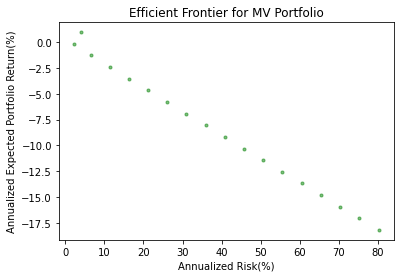

In [264]:
NoPoints = len(mv_backtest_mean)

colours = "green"
area = np.pi*3

plt.title('Efficient Frontier for MV Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(np.sqrt(mv_backtest_var * (trading_days_in_year /5)),mv_backtest_mean * (trading_days_in_year /5), s=area, c=colours, alpha =0.5)
plt.show()

### Naive Portfolio

In [252]:
thetas = np.arange(0, 1.05, 0.05)
thetas

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [253]:
naive_backtest_returns = pd.DataFrame(columns = thetas)

for date in daterange:
  print(date)
  dataset = get_mv_dataset_for_date(date)
  r, cov = get_sample_return_and_covariance(dataset)
  rets=[]
  for theta in thetas:
    ret = get_mv_backtest_return(date, theta)
    rets.append(ret)
  naive_backtest_returns.loc[date] = rets

2003-09-21 00:00:00
2003-09-28 00:00:00
2003-10-05 00:00:00
2003-10-12 00:00:00
2003-10-19 00:00:00
2003-10-26 00:00:00
2003-11-02 00:00:00
2003-11-09 00:00:00
2003-11-16 00:00:00
2003-11-23 00:00:00
2003-11-30 00:00:00
2003-12-07 00:00:00
2003-12-14 00:00:00
2003-12-21 00:00:00
2003-12-28 00:00:00
2004-01-04 00:00:00
2004-01-11 00:00:00
2004-01-18 00:00:00
2004-01-25 00:00:00
2004-02-01 00:00:00
2004-02-08 00:00:00
2004-02-15 00:00:00
2004-02-22 00:00:00
2004-02-29 00:00:00
2004-03-07 00:00:00
2004-03-14 00:00:00
2004-03-21 00:00:00
2004-03-28 00:00:00
2004-04-04 00:00:00
2004-04-11 00:00:00
2004-04-18 00:00:00
2004-04-25 00:00:00
2004-05-02 00:00:00
2004-05-09 00:00:00
2004-05-16 00:00:00
2004-05-23 00:00:00
2004-05-30 00:00:00
2004-06-06 00:00:00
2004-06-13 00:00:00
2004-06-20 00:00:00
2004-06-27 00:00:00
2004-07-04 00:00:00
2004-07-11 00:00:00
2004-07-18 00:00:00
2004-07-25 00:00:00
2004-08-01 00:00:00
2004-08-08 00:00:00
2004-08-15 00:00:00
2004-08-22 00:00:00
2004-08-29 00:00:00


In [254]:
naive_backtest_mean = naive_backtest_returns.mean()
naive_backtest_var = naive_backtest_returns.var()
print(naive_backtest_mean)
print(np.sqrt(naive_backtest_var))

0.00    0.000407
0.05    0.000459
0.10    0.000512
0.15    0.000564
0.20    0.000617
0.25    0.000669
0.30    0.000722
0.35    0.000774
0.40    0.000827
0.45    0.000879
0.50    0.000932
0.55    0.000984
0.60    0.001037
0.65    0.001089
0.70    0.001142
0.75    0.001194
0.80    0.001246
0.85    0.001299
0.90    0.001351
0.95    0.001404
1.00    0.001456
dtype: float64
0.00    0.008582
0.05    0.007926
0.10    0.007449
0.15    0.007187
0.20    0.007164
0.25    0.007381
0.30    0.007819
0.35    0.008444
0.40    0.009218
0.45    0.010106
0.50    0.011081
0.55    0.012122
0.60    0.013213
0.65    0.014344
0.70    0.015505
0.75    0.016690
0.80    0.017894
0.85    0.019114
0.90    0.020347
0.95    0.021590
1.00    0.022842
dtype: float64


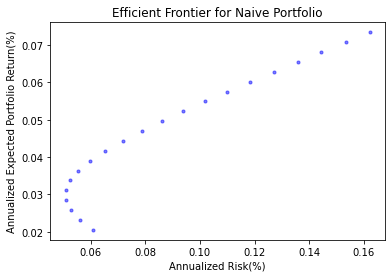

In [255]:
NoPoints = len(mv_backtest_mean)

colours = "blue"
area = np.pi*3

plt.title('Efficient Frontier for Naive Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(np.sqrt(naive_backtest_var * (trading_days_in_year /5)),naive_backtest_mean * (trading_days_in_year /5), s=area, c=colours, alpha =0.5)
plt.show()

### Combined Graph

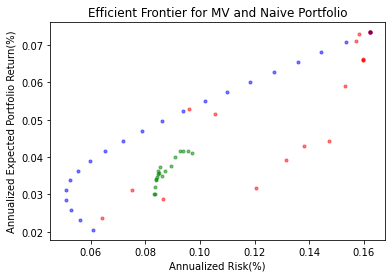

In [261]:
NoPoints = 21

area = np.pi*3

fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.title('Efficient Frontier for MV and Naive Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
ax1.scatter(np.sqrt(backtest_var * (trading_days_in_year /5)), backtest_mean * (trading_days_in_year /5),s=area, c="red", alpha =0.5)
ax1.scatter(np.sqrt(mv_backtest_var * (trading_days_in_year /5)),mv_backtest_mean * (trading_days_in_year /5), s=area, c="green", alpha =0.5)
ax1.scatter(np.sqrt(naive_backtest_var * (trading_days_in_year /5)),naive_backtest_mean * (trading_days_in_year /5), s=area, c="blue", alpha =0.5)
# plt.xlim(riskPoint.min(), riskPoint.max())
plt.show()

## Cross validation

In [ ]:
# model = torch.exp(torch.matmul(x, a)) / (torch.exp (torch.matmul(x, a)) + torch.exp(torch.matmul(x, b)))

def train_epoch(dataloader):
    train_loss,train_correct=0.0,0
    for data in dataloader:

        x = data[:,:-1]
        y = data[:,-1]

        y_output = torch.exp(torch.matmul(x, a)) / (torch.exp (torch.matmul(x, a)) + torch.exp(torch.matmul(x, b)))
        loss = loss_fn(y_output, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item() * x.size(0)

    return train_loss
  
def valid_epoch(dataloader):

    valid_loss, val_correct = 0.0, 0
    for data in dataloader:

        x = data[:,:-1]
        y = data[:,-1]

        y_output = torch.exp(torch.matmul(x, a)) / (torch.exp (torch.matmul(x, a)) + torch.exp(torch.matmul(x, b)))

        loss = loss_fn(y_output, y)

        valid_loss+=loss.item() * x.size(0)

    return valid_loss

In [ ]:
history = {'train_loss': [], 'test_loss': []}
 
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    for epoch in range(n_epochs):
        train_loss=train_epoch(train_loader)
        test_loss=valid_epoch(test_loader)

        train_loss = train_loss / len(train_loader.sampler)
        test_loss = test_loss / len(test_loader.sampler)

        if epoch % 1 == 0:
            print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f}".format(epoch + 1,n_epochs,train_loss,test_loss))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)

Fold 1


NameError: ignored

In [ ]:
print(a, b)

# MV Portfolio

## Optimization using linear programming

(Reference: https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios)


In [309]:
TERMINATION = 10**-9

In [310]:
#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):
    
    #dependencies
    from scipy.optimize import linprog
    import numpy as np
    
    c = (np.multiply(-1, MeanReturns))
    A = np.ones([PortfolioSize,1]).T
    b=[1] 
    res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex') 
    
    return res

In [311]:
#function obtains minimal risk portfolio 

from scipy import optimize 

def MinimizeRisk(CovarReturns, PortfolioSize):
    
    def  f(x, CovarReturns):
        func = np.matmul(np.matmul(x, CovarReturns), x.T) 
        return func

    def constraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    
    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = TERMINATION)
    
    return opt

In [312]:
def print_min_variance_portfolio(mean_returns, cov_returns):
    number_of_assets = len(mean_returns)
    result = MinimizeRisk(cov_returns, number_of_assets)

    print()
    minRiskWeights = result.x
    minRiskExpPortfolioReturn = np.matmul(mean_returns.T, minRiskWeights)
    print("Expected Return of Minimum Risk Portfolio:  %7.6f" % minRiskExpPortfolioReturn)
    minRisk = np.matmul(np.matmul(minRiskWeights, cov_returns), minRiskWeights.T) 
    print("Variance of Minimum Risk Portfolio : %7.6f" % minRisk)
    print("S.D. of Minimum Risk Portfolio : %7.6f" % np.sqrt(minRisk))
    threshold = 1e-3
    print("Weights (showing only those > %.6f): " % threshold)
    for i in range(0, number_of_assets):
        if result.x[i] > threshold:
            print(f"{mean_returns.index[i]}\t{result.x[i]:.6f}")
    print('Assets Considered:')
    print(mean_returns.index.to_numpy())

In [313]:
#function obtains Minimal risk and Maximum return portfolios

#dependencies
import numpy as np
from scipy import optimize 

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    
    def  f(x,CovarReturns):
         
        func = np.matmul(np.matmul(x,CovarReturns ), x.T)
        return func

    def constraintEq(x):
        AEq=np.ones(x.shape)
        bEq=1
        EqconstraintVal = np.matmul(AEq,x.T)-bEq 
        return EqconstraintVal
    
    def constraintIneq(x, MeanReturns, R):
        AIneq = np.array(MeanReturns)
        bIneq = R
        IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
        return IneqconstraintVal
    

    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq},
            {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                        x0 = xinit,   bounds = bnds, constraints = cons, tol = TERMINATION)
    
    return  opt

In [314]:
print_min_variance_portfolio(r, cov)


Expected Return of Minimum Risk Portfolio:  -0.149523
Variance of Minimum Risk Portfolio : 0.009581
S.D. of Minimum Risk Portfolio : 0.097884
Weights (showing only those > 0.001000): 
l_Close	0.905878
h_Close	0.094122
Assets Considered:
['l_Close' 'h_Close']


In [315]:
#Maximal expected portfolio return computation for the k-portfolio
result1 = MaximizeReturns(r, 2)
maxReturnWeights = result1.x
maxExpPortfolioReturn = np.matmul(r.T, maxReturnWeights)
print("Maximal Expected Portfolio Return:   %7.6f" % maxExpPortfolioReturn )

Maximal Expected Portfolio Return:   0.000000


In [316]:
#expected portfolio return computation for the minimum risk k-portfolio 
result2 = MinimizeRisk(cov, 2)
minRiskWeights = result2.x
minRiskExpPortfolioReturn = np.matmul(r.T, minRiskWeights)
print("Expected Return of Minimum Risk Portfolio:  %7.6f" % minRiskExpPortfolioReturn)

Expected Return of Minimum Risk Portfolio:  -0.149523


In [320]:
#compute efficient set for the maximum return and minimum risk portfolios
increment = 0.01
low = minRiskExpPortfolioReturn
high = maxExpPortfolioReturn

#initialize optimal weight set and risk-return point set
xOptimal =[]
minRiskPoint = []
expPortfolioReturnPoint =[]

#repeated execution of function MinimizeRiskConstr to determine the efficient set 
while (low < high):
    
    result3 = MinimizeRiskConstr(r, cov, 2, low)
    xOptimal.append(result3.x)
    expPortfolioReturnPoint.append(low)
    low = low+increment
    
#gather optimal weight set    
xOptimalArray = np.array(xOptimal)

#obtain annualized risk for the efficient set portfolios 
#for trading days = 251
minRiskPoint = np.diagonal(np.matmul((np.matmul(xOptimalArray,cov)),\
                                     np.transpose(xOptimalArray)))
riskPoint =   np.sqrt(minRiskPoint) 

#obtain expected portfolio annualized return for the 
#efficient set portfolios, for trading days = 251
retPoint = np.array(expPortfolioReturnPoint) 

#display efficient set portfolio parameters
print("Size of the  efficient set:", xOptimalArray.shape )
print("Optimal weights of the efficient set portfolios: \n", xOptimalArray)
print("Annualized Risk and Return of the efficient set portfolios: \n", \
                                                np.c_[riskPoint, retPoint])

Size of the  efficient set: (15, 2)
Optimal weights of the efficient set portfolios: 
 [[ 9.03663741e-01  9.63362594e-02]
 [-6.99435915e-06  9.98652333e-01]
 [-1.45120188e-05  9.97203837e-01]
 [-2.20296783e-05  9.95755341e-01]
 [-2.95473998e-05  9.94306844e-01]
 [-3.70649972e-05  9.92858348e-01]
 [-4.45826568e-05  9.91409852e-01]
 [-5.21003162e-05  9.89961356e-01]
 [-5.96181202e-05  9.88512860e-01]
 [-6.71356356e-05  9.87064364e-01]
 [-7.46531138e-05  9.85615867e-01]
 [-8.21709547e-05  9.84167371e-01]
 [-8.96888312e-05  9.82718876e-01]
 [-9.72062735e-05  9.81270379e-01]
 [-1.04724187e-04  9.79821883e-01]]
Annualized Risk and Return of the efficient set portfolios: 
 [[ 0.09788576 -0.14952253]
 [ 0.24039177 -0.13952253]
 [ 0.24004295 -0.12952253]
 [ 0.23969413 -0.11952253]
 [ 0.23934531 -0.10952253]
 [ 0.23899649 -0.09952253]
 [ 0.23864767 -0.08952253]
 [ 0.23829885 -0.07952253]
 [ 0.23795003 -0.06952253]
 [ 0.23760121 -0.05952253]
 [ 0.2372524  -0.04952253]
 [ 0.23690358 -0.03952253]
 

In [ ]:
# #compute efficient set for the maximum return and minimum risk portfolios
# increment = 0.000001
# low = minRiskExpPortfolioReturn
# high = maxExpPortfolioReturn

# #initialize optimal weight set and risk-return point set
# xOptimal =[]
# minRiskPoint = []
# expPortfolioReturnPoint =[]

# #repeated execution of function MinimizeRiskConstr to determine the efficient set 
# while (low < high):
    
#     result3 = MinimizeRiskConstr(r, cov, 2, low)
#     xOptimal.append(result3.x)
#     expPortfolioReturnPoint.append(low)
#     low = low+increment
    
# #gather optimal weight set    
# xOptimalArray = np.array(xOptimal)

# #obtain annualized risk for the efficient set portfolios 
# #for trading days = 251
# minRiskPoint = np.diagonal(np.matmul((np.matmul(xOptimalArray,cov)),\
#                                      np.transpose(xOptimalArray)))
# riskPoint =   np.sqrt(minRiskPoint*trading_days_in_year) 

# #obtain expected portfolio annualized return for the 
# #efficient set portfolios, for trading days = 251
# retPoint = trading_days_in_year*np.array(expPortfolioReturnPoint) 

# #display efficient set portfolio parameters
# print("Size of the  efficient set:", xOptimalArray.shape )
# print("Optimal weights of the efficient set portfolios: \n", xOptimalArray)
# print("Annualized Risk and Return of the efficient set portfolios: \n", \
#                                                 np.c_[riskPoint, retPoint])

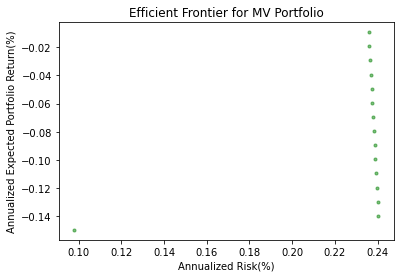

In [321]:
#Graph Efficient Frontier

NoPoints = riskPoint.size

colours = "green"
area = np.pi*3

plt.title('Efficient Frontier for MV Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(riskPoint, retPoint, s=area, c=colours, alpha =0.5)
plt.show()

# Naive Portfolio

In [ ]:
naive_risks = []
naive_returns = []

for x in np.arange(0, 1, 0.01):
  weights = [x, 1-x]
  risk = np.matmul((np.matmul(weights,cov)),np.transpose(weights)) * trading_days_in_year
  naive_risks.append(np.sqrt(risk))

  #obtain expected portfolio annualized return for the 
  #efficient set portfolios, for trading days = 251
  ret = trading_days_in_year*(np.matmul(weights,r))
  naive_returns.append(ret)

#display efficient set portfolio parameters
# print("Size of the  efficient set:", xOptimalArray.shape )
# print("Optimal weights of the efficient set portfolios: \n", xOptimalArray)
print("Annualized Risk and Return of the efficient set portfolios: \n", \
                                                np.c_[naive_risks, naive_returns])

In [ ]:
NoPoints = len(naive_risks)

colours = "blue"
area = np.pi*3

plt.title('Efficient Frontier for Naive Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(naive_risks, naive_returns, s=area, c=colours, alpha =0.5)
plt.show()

# Combined Graph

In [ ]:
NoPoints = riskPoint.size

colours = "blue"
area = np.pi*3


fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.title('Efficient Frontier for MV and Naive Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
ax1.scatter(riskPoint, retPoint, s=area, c="green", alpha =0.5)
ax1.scatter(naive_risks, naive_returns, s=area, c="blue", alpha =0.5)
# plt.xlim(riskPoint.min(), riskPoint.max())
plt.show()

In [ ]:
cov

In [ ]:
print(high_risk["Close"].var())
print(high_risk["Close"].var() * trading_days_in_year)
print(high_risk["Close"].pct_change().var())
print(high_risk["Close"].pct_change().var() * trading_days_in_year)
print(np.sqrt(high_risk["Close"].pct_change().var() * trading_days_in_year))